# Wykrywanie anomalii sieciowych

## Zadanie

Wytrenować autoenkoder na załaczonych dnaych pomiarowych z sieci AGH. Paietać, że dane to szereg czasowy i autoenkoder trenujemy na oknie o romiarze $w$. Zbudowanie PCA tez będzie unznane, ale na najnizsza ocene umożliwiająca zaliczenie.

Uwagi

- Główne etapy analizy powinny byc rodzieleone na komórki
- Rozwiązanie przysyłamy w formie notatnika z wynikami
- Należy skomentować podjete akcje

## Dane grupy

- Maciej Bobrek
- Krzysztof Góra

Na początku wczytujemy dane i bilioteki

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


FILE = 'data/stats_clean.csv'
data = pd.read_csv(FILE, parse_dates=['timestamp'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103194 entries, 0 to 103193
Data columns (total 31 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   timestamp        103194 non-null  datetime64[ns]
 1   b6-ucirtr        102850 non-null  float64       
 2   ucirtr-b6        102850 non-null  float64       
 3   b6-b1rtr         102850 non-null  float64       
 4   b1rtr-b6         102850 non-null  float64       
 5   b1-ftjrtr        102850 non-null  float64       
 6   ftjrtr-b1        102850 non-null  float64       
 7   cyfronet-ucirtr  102850 non-null  float64       
 8   ucirtr-cyfronet  102850 non-null  float64       
 9   ftj-b6rtr        102850 non-null  float64       
 10  b6rtr-ftj        102850 non-null  float64       
 11  b1-b6rtr         102850 non-null  float64       
 12  b6rtr-b1         102850 non-null  float64       
 13  cyfronet-ftjrtr  102850 non-null  float64       
 14  ftjrtr-cyfronet  102

In [4]:
data.head()

,timestamp,b6-ucirtr,ucirtr-b6,b6-b1rtr,b1rtr-b6,b1-ftjrtr,ftjrtr-b1,cyfronet-ucirtr,ucirtr-cyfronet,ftj-b6rtr,...,ftj-ucirtr,ucirtr-ftj,uci-ftjrtr,ftjrtr-uci,uci-b1rtr,b1rtr-uci,ftj-b1rtr,b1rtr-ftj,uci-b6rtr,b6rtr-uci
0,2020-12-13 15:25:03,4063963.0,2099589.0,1728848.0,52632.0,2352.0,16766.0,10425570.0,39459770.0,82891.0,...,5046928.0,1831919.0,1845690.0,5044319.0,8395469.0,2898609.0,16534.0,2314.0,2104685.0,4062125.0
1,2020-12-13 15:30:03,4115472.0,2033890.0,1675340.0,46513.0,2468.0,17191.0,11739436.0,37856957.0,29267.0,...,5468130.0,1557696.0,1562774.0,5506855.0,8389581.0,3139075.0,17260.0,2481.0,2033834.0,4113483.0
2,2020-12-13 15:35:03,4460894.0,1967785.0,1717643.0,46969.0,2572.0,17776.0,14880181.0,22968938.0,19467.0,...,4910226.0,1682946.0,1674507.0,4880848.0,7446018.0,2968990.0,17838.0,2586.0,1960732.0,4464048.0
3,2020-12-13 15:40:03,4180486.0,2008196.0,1616511.0,47048.0,2451.0,16932.0,13961237.0,23170350.0,24386.0,...,5883441.0,2946501.0,2943126.0,5899514.0,7788634.0,4172991.0,16892.0,2439.0,2014920.0,4178625.0
4,2020-12-13 15:45:03,3744176.0,3335874.0,1746441.0,56408.0,2834.0,17673.0,14983896.0,24006404.0,29554.0,...,4670566.0,2467885.0,2503704.0,4727394.0,7436740.0,3538008.0,17450.0,2797.0,3334540.0,3739133.0


### Analiza

### Standaryzacja

Usuwamy kolumne timestamp i dane sprowadzamy do zakresu [-$\sigma$, $\sigma$], aby ułatwić przepływ gradientów. Następnie dzielimy je na okna o rozmiarze 30 próbek.

In [5]:
WINDOW_SIZE = 30

data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
values = data.drop(columns=['timestamp']).values

scaler = StandardScaler()
values_scaled = scaler.fit_transform(values)

In [6]:


def create_windows(data, window_size):
    windows = []
    for i in range(len(data) - window_size + 1):
        windows.append(data[i:i+window_size])
    return np.array(windows)

windows = create_windows(values_scaled, WINDOW_SIZE)

### Przygotowanie danych do uczenia

Dzielimy zbiór na dane treningowe i testowe aby następnie utworzyć obiekt dataloader

In [7]:


data = windows.reshape((windows.shape[0], -1))
data = torch.tensor(data, dtype=torch.float32)

train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = random_split(TensorDataset(data, data), [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### Autoenkoder

Tworzymy model autoenkodera, który składa się z dwóch części: enkodera i dekodera. Optymalizator - Adam, funkcja straty - błąd średniokwadratowy

In [8]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
input_dim = data.shape[1]
encoding_dim = 8
model = Autoencoder(input_dim, encoding_dim)
crit = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=1e-3)  

### Uczenie 

Trenujemy model przez 10 epok i patrzymy na los danych testowych i treningowych.

In [10]:
epochs = 30
train_loss = []
test_loss = []

epochs_run = 0


patience = 5  
best_test_loss = float('inf')
early_stop_counter = 0

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for data in train_loader:
        inputs, _ = data
        outputs = model(inputs)
        loss = crit(outputs, inputs)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_loss.append(avg_train_loss)

    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, _ = data
            outputs = model(inputs)
            loss = crit(outputs, inputs)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_loss.append(avg_test_loss)

    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss} Test Loss: {avg_test_loss}")
    epochs_run += 1

    # Early stopping logic
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping triggered")
        break

Epoch 1 Train Loss: 0.8348730574352924 Test Loss: 0.8009638220396235
Epoch 2 Train Loss: 0.7823998981160164 Test Loss: 0.7914570866161335
Epoch 3 Train Loss: 0.776637659717144 Test Loss: 0.788141823320144
Epoch 4 Train Loss: 0.773402910544825 Test Loss: 0.784622471866489
Epoch 5 Train Loss: 0.7701364419470498 Test Loss: 0.7816464827739247
Epoch 6 Train Loss: 0.7682095405622847 Test Loss: 0.780146555804168
Epoch 7 Train Loss: 0.7669944466899129 Test Loss: 0.7795354274809824
Epoch 8 Train Loss: 0.766226163446231 Test Loss: 0.7788615669377299
Epoch 9 Train Loss: 0.7655737093743625 Test Loss: 0.7779915726064338
Epoch 10 Train Loss: 0.7649514113289518 Test Loss: 0.7774625985794824
Epoch 11 Train Loss: 0.7646118678190235 Test Loss: 0.7773198579230909
Epoch 12 Train Loss: 0.7643135512607749 Test Loss: 0.7769856078674782
Epoch 13 Train Loss: 0.7638190723216659 Test Loss: 0.7763443801488328
Epoch 14 Train Loss: 0.7633732185955875 Test Loss: 0.7762267441484457
Epoch 15 Train Loss: 0.763048583978

### Wizualizacja

Wykres Lossu dla danych treningowych i testowych

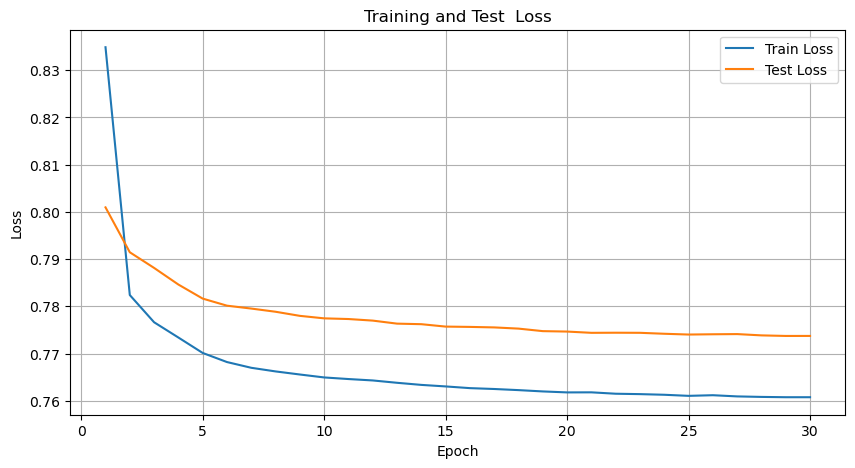

In [11]:

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs_run + 1), np.array(train_loss), label='Train Loss')
plt.plot(range(1, epochs_run + 1), np.array(test_loss), label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test  Loss')
plt.legend()
plt.grid(True)
plt.show()

### Wykrycie anomalii

Najpierw obliczamy błąd rekonstrukcji, ustalamy dany próg wykrycia anomalii i potem powtarzamy czynność dla zbioru testowego.


In [12]:
train_loss = []
for batch in train_dataset:
    prediction_train = model.forward(batch[0])
    train_loss.append(np.mean(np.power(batch[0].detach().numpy() - prediction_train.detach().numpy(), 2)))
threshold = np.percentile(train_loss, 99)
print(f'threshold: {threshold}')

test_loss = []
for batch in test_dataset:
    prediction_test = model.forward(batch[0])
    test_loss.append(np.mean(np.power(batch[0].detach().numpy() - prediction_test.detach().numpy(), 2)))

anomalies = test_loss > threshold
print(f'Number of anomalies: {np.sum(anomalies)}')

threshold: 7.574615168571461
Number of anomalies: 215


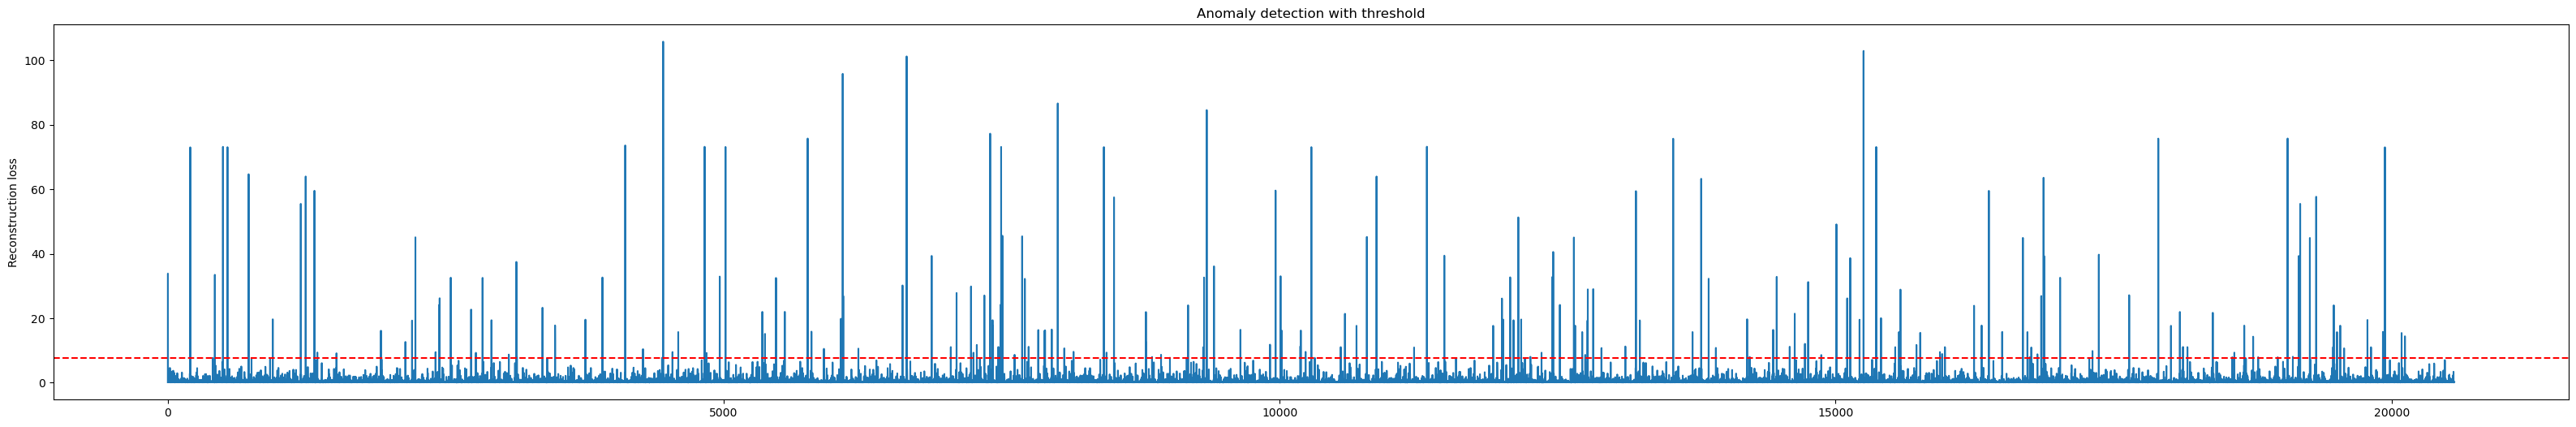

In [13]:
plt.figure(figsize=(40, 6))
plt.plot(test_loss, label='Reconstruction loss')
plt.axhline(y=threshold, color='r', linestyle='--', label='threshold')
plt.title('Anomaly detection with threshold')
plt.ylabel('Reconstruction loss')
plt.show()